# Objective
- We want to train a model to predict a car's price based on it's mileage.
- we'll use linear regression with one variable.
- Linear regression aims to find a linear relation of the form y = ax + b;
    - With y being the output, x being the input.
    - a and b are the weight and bias respectively. Our goal is to find optimal values for them.
- The output (price) is called a label, and the inputs (the mileage) are called features.
- We will have a linear equation of the form price = weight * mileage + bias.

# Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas import DataFrame

# Loading & Exploring Data
- We'll load the data from a csv file.
- Use a pandas dataframe to store it.
- We will also display graphs for the mileage and price.

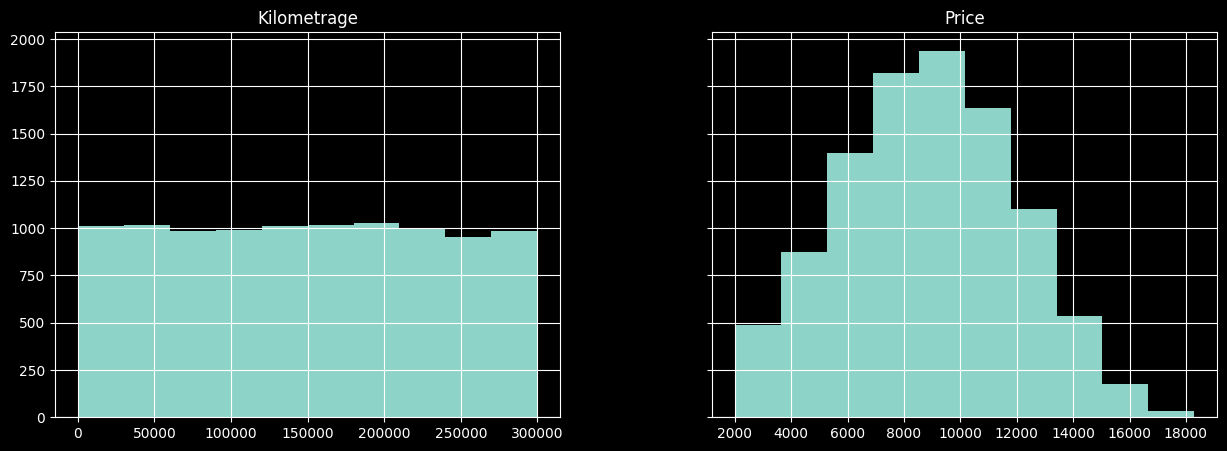

In [14]:
df = pd.read_csv('car_price_dataset.csv')

## Only Keep the columns that are needed
# Kilometrage, Price
originalDf = df[['Kilometrage', 'Price']].copy()
df = df[['Kilometrage', 'Price']]

df.hist(figsize=(15,5),sharey=True)

# Transform miles to km
df['Kilometrage'] = df['Kilometrage'] * 1.60934

## Train & Test Data
- We should also split the data into train and test data.
- This let's us evaluate the model's performance on a dataset that it wasn't trained on.
- This gives us a more accurate evaluation.

In [4]:
train_to_test_ratio = 0.8
train_size = math.ceil(df.shape[0] * train_to_test_ratio)
train_df = df.iloc[:train_size, :].copy()
train_df.reset_index(drop=True, inplace=True)

test_df = df.iloc[train_size:, :].copy()
test_df.reset_index(drop=True, inplace=True)


sample = test_df.sample(300)  # A sample from the test set to plot later

# Normalization
- Normalization is used to transform the range of a feature into a smaller one. (in this case, the mileage is the feature).
- This helps make better predictions, increase training speed, and avoid overflows.
- Since the frequency of the mileage follows (roughly) a uniform distribution, then we should use linear scaling.
- Linear scaling transform the values into a standard $[0,1]$ range
$$x = \frac{x'-x_{min}}{x_{max}-x_{min}}$$
- Where :
	- $x$ is the initial value.
	- $x'$ is the normalized value
	- $x_{max},x_{min}$ are the minimum and maximum values of the dataset.

- We should also normalize the label (price) inorder to avoid overflows.

In [5]:
max_kilometrage = train_df["Kilometrage"].max()
min_kilometrage = train_df["Kilometrage"].min()
train_df["Kilometrage"] = (train_df["Kilometrage"] - min_kilometrage) / (
    max_kilometrage - min_kilometrage
)

max_price = train_df["Price"].max()
min_price = train_df["Price"].min()
train_df["Price"] = (train_df["Price"] - min_price) / (max_price - min_price)


# Loss Function
- The loss is the distance between the predicted value, and the actual value from the dataset.
- Here we calculate the Mean Square Error, which is the average of the squared difference of each example in a set of examples.
- $$MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)^2$$
- Where :
    - $M$ is the size of the set of examples.
    - $y_i$ is the output (price) of the $i^{th}$ example.
    - $x_i$ is the input (kilometrage) of the $i^{th}$ example.
    - $w$ is the weight.
    - $b$ is the bias.
- However, since data is normalized, we need to denormalize it first.
- Note that the below function is not used for training our model. It is only used to calculate the final loss of our model.

In [6]:
def mse_normalized(batch: DataFrame, b, w1):
    # Calculate denormalized loss for normalized data
    denormalized_b = b * (max_price - min_price) + min_price
    denormalized_w1 = w1 * (max_price - min_price) / (max_kilometrage - min_kilometrage)

    errors = (
        batch["Price"] * (max_price - min_price) + min_price - (
            denormalized_b + denormalized_w1 * (
                batch["Kilometrage"] * (max_kilometrage - min_kilometrage)
                + min_kilometrage
            )
        )
    )
    return np.mean(errors**2)

# This accepts denormalized data
def mse(batch: DataFrame, b, w1):
    errors = batch["Price"] - (b + w1 * batch["Kilometrage"])
    return np.mean(errors**2)

# Gradient Descent
- As we've seen above, linear regression aims to produce optimal weights and bias.
- However, what does optimal weights and bias actually mean ?
- Optimal weights and bias are the ones that, when used to predict examples, produce the minimal loss.
- Gradient Descent is a technique that iteratively finds the weights and bias that produce the lowest loss.
## Process
- Start with weights and bias at 0.
- For each weight, and the bias : determine the direction to move them that reduces loss.
- Move a small amount in that direction.
- Repeat until loss can't be reducer further (the modal converges)
## Hyperparameters
- Hyperparameters are variables that control different aspects of learning :
    1. **Learning Rate:** It determines the magnitude of changes made to the weights and bias at each iteration. Lower values cause convergence to slow down, higher values cause the model to not converge.
    2. **Batch Size:** The number of examples of the dataset to be treated in each iteration.
    3. **Epochs:** It determines how many times each example in the dataset has to be processed. Higher values improve the model accuracy, but increase training time.

In [7]:
def gradient_descent(
    dataset: DataFrame, batch_size: int, learning_rate: float, epochs: int
):
    loss_history = []
    b = 0  # bias
    w1 = 0  # weight
    iteration_count = math.ceil(dataset.shape[0] * epochs / batch_size)

    for iter in range(iteration_count):
        batch = dataset.sample(batch_size, ignore_index=True)
        loss = mse_normalized(batch, b, w1)
        loss_history.append(loss)

        # Calculate slope of the loss function with respect to w0 and w1
        # The bias first :

        b = move_bias(b, w1, learning_rate, batch)
        w1 = move_weight(b, w1, learning_rate, batch)
    return [b, w1, loss_history, iter]


## Moving the coefficients
- We need to move the weight and the bias in the direction that reduces loss.
- First, we need to find that direction for each of the weight of the bias.
- We need to calculate the slope of the loss function in relation to the weight, and to the bias.
- For the weight :
    - Let $M$ be the batch size. then the MSE is 
    $$MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)^2$$
    - In order to move the weight in the direction that reduces loss, then we need the partial derivative of the loss in regards to the weight
    $$\text{weight slope} = \frac{\delta}{\delta w} MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i) * 2 x_{i}$$
    - So the new weight will move by a small amount in the inverse direction of the above value
    $$w = w - \epsilon * \text{weight slope}$$
- Using a similar method, we can calculate the bias slope 
$$\text{bias slope} =  2 * \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)$$

In [8]:
def move_bias(b, w1, learning_rate, batch):
    slope = batch["Price"] - (b + w1 * batch["Kilometrage"])
    slope = -2 * slope.mean()
    return b - learning_rate * slope

def move_weight(b, w1, learning_rate, batch):
    slope = (batch["Price"] - (b + w1 * batch["Kilometrage"])) * batch["Kilometrage"]
    slope = -2 * slope.mean()
    return w1 - learning_rate * slope


In [9]:
[b, w1, loss_history, iter] = gradient_descent(train_df, 2000, 0.0150, 1000)
print("Normalized bias: ", b)
print("Normalized weight: ", w1)

denormalized_b = b * (max_price - min_price) + min_price
denormalized_w1 = w1 * (max_price - min_price) / (max_kilometrage - min_kilometrage)
print("Denormalized bias: ", denormalized_b)
print("Denormalized weight: ", denormalized_w1)

print("Loss on test data : ", mse(test_df, denormalized_b, denormalized_w1))
print("Loss on train data : ", mse_normalized(train_df, b, w1))

print("Iterations: ", iter)

Normalized bias:  0.6001910123577723
Normalized weight:  -0.3618205475348094
Denormalized bias:  11783.713692444046
Denormalized weight:  -0.012219441165798189
Loss on test data :  7056151.828538147
Loss on train data :  6666138.423305657
Iterations:  3999


In [ ]:
def predict(x, b, w1):
    # Normalize the input
    x = (x - min_kilometrage) / (max_kilometrage - min_kilometrage)
    result = b + w1 * x
    # Denormalize the output
    return round(result * (max_price - min_price) + min_price)


# From 0 to 200000 miles in steps of 10000
miles = np.arange(0, 200000, 10000)
prices = np.array([predict(x, b, w1) for x in miles])
tabular = pd.DataFrame({"Kilometrage": miles, "Price ($)": prices})
print(tabular)

Text(0.5, 1.0, 'Linear Regression')

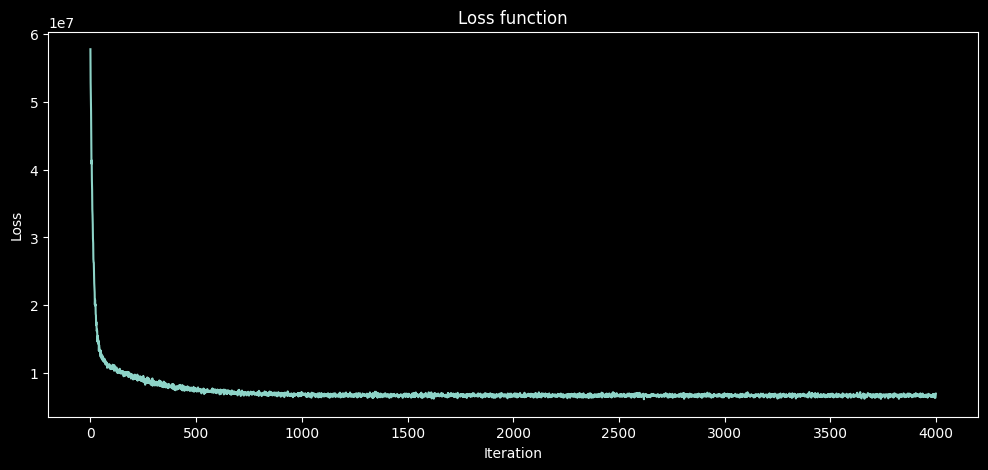

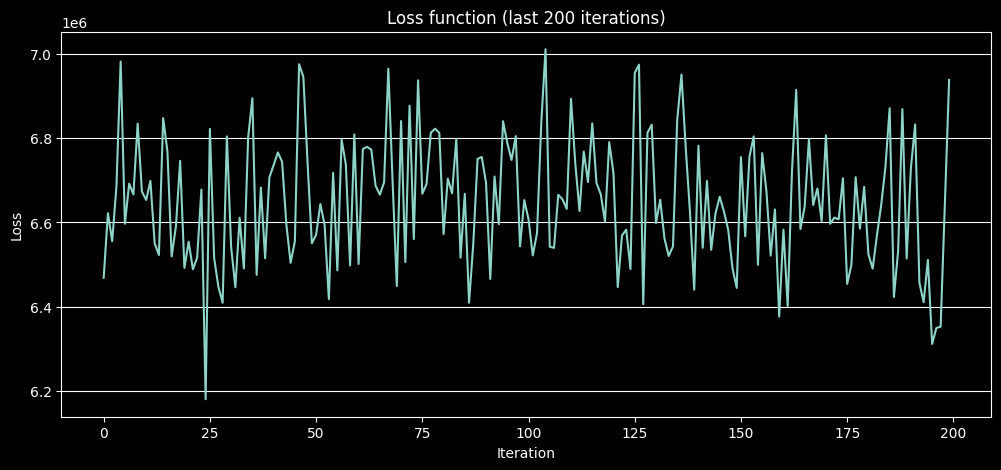

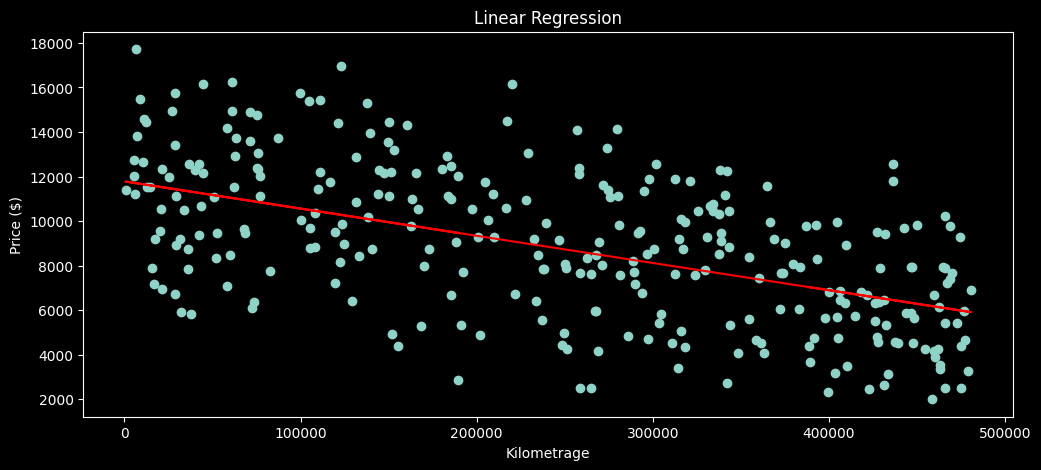

In [11]:
from matplotlib.axes import Axes


loss_fig, loss_ax = plt.subplots()
loss_fig.set_size_inches(12, 5)
loss_ax: Axes = loss_ax
loss_ax.plot(loss_history, label="Loss")
loss_ax.set_xlabel("Iteration")
loss_ax.set_ylabel("Loss")
loss_ax.set_title("Loss function")


# Visualize last 200 iterations
last_loss_fig, last_loss_ax = plt.subplots()
last_loss_fig.set_size_inches(12, 5)
last_loss_ax: Axes = last_loss_ax
last_loss_ax.grid(axis="y")
last_loss_ax.plot(loss_history[-200:], label="Loss")
last_loss_ax.set_xlabel("Iteration")
last_loss_ax.set_ylabel("Loss")
last_loss_ax.set_title("Loss function (last 200 iterations)")


# Plot the data along with the line
data_plot, data_ax = plt.subplots()
data_plot.set_size_inches(12, 5)
data_ax: Axes = data_ax
data_ax.scatter(sample["Kilometrage"], sample["Price"])
data_ax.plot(
    sample["Kilometrage"],
    denormalized_b + denormalized_w1 * sample["Kilometrage"],
    color="red",
)
data_ax.set_xlabel("Kilometrage")
data_ax.set_ylabel("Price ($)")
data_ax.set_title("Linear Regression")

## Results Remarks
- The weight is negative, which makes sense since the car's value decreases as it's mileage increases.
- In the last 200 iterations, the loss function is unstable (bounces from 6.4 to 6.8 million). This is due to not using the full dataset in each iteration (full-batch stochastic gradient descent), but instead using a random sample from it (mini-batch stochastic gradient descent)

# Normal Equation
- Normal equation is another method to calculate the linear regression weights and balance to minimize the loss.
- Contrary to gradient descent, it is not an iterative method. Meaning that it finds the coeffcients directly.
- It uses the following formula
$$\theta = (X^{T}X)^{-1}X^Ty$$
- Where :
    - $\theta$ is the vector of the optimal value of the coefficients.
    - $X$ is a matrix where each column represents an input feature's values for all the examples.
    - $y$ is the vector of output values for each instance

In [12]:
def normal_equation(dataset: DataFrame):
    kilos = dataset["Kilometrage"]
    # Create a matrix X with the first column being 1s and the second column being the kilometrage values from the dataset
    X = np.stack([np.ones(kilos.size), kilos.values], axis=1)
    Y = dataset["Price"].values
    # Apply the normal equation formula
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)


ne_b, ne_w = normal_equation(train_df)
print("Normalized Bias: ", ne_b)
print("Normalized Weight: ", ne_w)
denormalized_ne_b = ne_b * (max_price - min_price) + min_price
denormalized_ne_w = ne_w * (max_price - min_price) / (max_kilometrage - min_kilometrage)
print("Denormalized Bias: ", denormalized_ne_b)
print("Denormalized Weight: ", denormalized_ne_w)
print("Loss: on test data", mse(test_df, denormalized_ne_b, denormalized_ne_w))
print("Loss: on train data", mse_normalized(train_df, ne_b, ne_w))

Normalized Bias:  0.6012266575671953
Normalized Weight:  -0.36182983666930846
Denormalized Bias:  11800.59574500285
Denormalized Weight:  -0.012219754879414693
Loss: on test data 7058067.702677214
Loss: on train data 6665839.422833262


## Remarks
- This method is a lot faster than gradient descent. Since the dataset's size is pretty small.
- It produced roughly the same bias, weight and loss.

# Final Results

Bias:  11842.594738292799
Weight:  -0.020046036660471455
Loss on test data : 6898025.399426553
Loss on train data : 6705509.553513855



             Method       Bias  Weight  Loss on test data  Loss on train data
0  Gradient Descent  11783.714  -0.012        7056151.829         6666138.423
1   Normal Equation  11800.596  -0.012        7058067.703         6665839.423
2           Sklearn  11842.595  -0.020        6898025.399         6705509.554


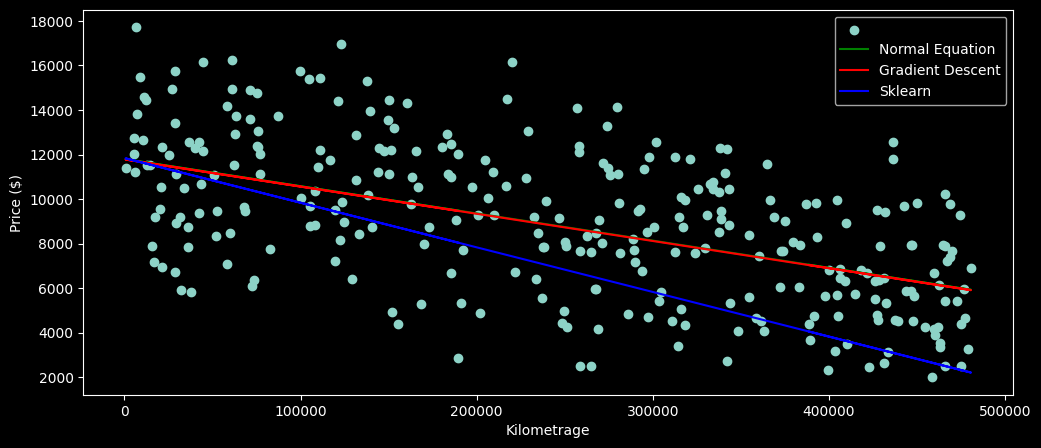

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

final_data_plot, final_data_ax = plt.subplots()
final_data_plot.set_size_inches(12, 5)
final_data_ax: Axes = final_data_ax
final_data_ax.scatter(sample["Kilometrage"], sample["Price"])


final_data_ax.plot()
final_data_ax.plot(
    sample["Kilometrage"],
    denormalized_ne_b + denormalized_ne_w * sample["Kilometrage"],
    color="green",
)
final_data_ax.plot(
    sample["Kilometrage"],
    denormalized_b + denormalized_w1 * sample["Kilometrage"],
    color="red",
)

# Compare with sklearn

X_train, X_test, Y_train, Y_test = train_test_split(
    originalDf["Kilometrage"].values.reshape(-1, 1),
    originalDf["Price"].values.reshape(-1, 1),
    test_size=0.2,
    random_state=0,
)

model = LinearRegression()
model.fit(X_train, Y_train,)

print("Bias: ", model.intercept_[0])
print("Weight: ", model.coef_[0][0])
print("Loss on test data :", mean_squared_error(Y_test, model.predict(X_test),))
print("Loss on train data :", mean_squared_error(Y_train, model.predict(X_train)))


final_data_ax.plot(
    sample["Kilometrage"],
    model.intercept_ + model.coef_[0] * sample["Kilometrage"],
    color="blue",
)

final_data_ax.legend(["", "Normal Equation", "Gradient Descent", "Sklearn"])

final_data_ax.set_xlabel("Kilometrage")
final_data_ax.set_ylabel("Price ($)")

print("\n\n")
table = pd.DataFrame(
    {
        "Method": ["Gradient Descent", "Normal Equation", "Sklearn"],
        "Bias": [
            round(denormalized_b, 3),
            round(denormalized_ne_b, 3),
            round(model.intercept_[0], 3),
        ],
        "Weight": [
            round(denormalized_w1, 3),
            round(denormalized_ne_w, 3),
            round(model.coef_[0][0], 3),
        ],
        "Loss on test data": [
            round(mse(test_df, denormalized_b, denormalized_w1), 3),
            round(mse(test_df, denormalized_ne_b, denormalized_ne_w), 3),
            round(mean_squared_error(Y_test, model.predict(X_test)), 3),
        ],
        "Loss on train data": [
            round(mse_normalized(train_df, b, w1), 3),
            round(mse_normalized(train_df, ne_b, ne_w), 3),
            round(mean_squared_error(Y_train, model.predict(X_train)), 3),
        ],
    }
)

print(table)

## Final Remarks
- All of gradient descent, normal equation, and sklearn have similar loss on test tada at around 7 million.
- They also have similar biases.
- However, gradient descent and normal equation have a weight of around $-0.012$ while sklearn linear regression has a weight of around $-0.020$